In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns
import math

import os 

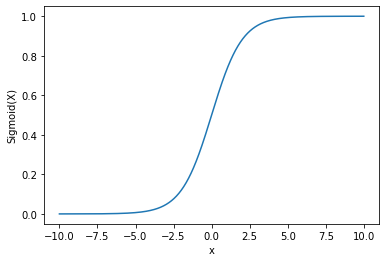

In [2]:
x = np.linspace(-10, 10, 1000)
z = 1/(1 + np.exp(-x))
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.savefig("Sigmoid.png")
plt.show()

In [3]:
#loading the data 
path=os.path.join("DATA","prosper_data.csv") #Imported this way to facilitate reading the data regardless the operating system
df_Data=pd.read_csv(path) 

path2=os.path.join("DATA","prosper_definitions.csv") 
df_Def=pd.read_csv(path2)

In [4]:
df_Def.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Variable     54 non-null     object
 1   Category     54 non-null     object
 2   Description  54 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


In [5]:
df_Def.Category.unique()

array(['member', 'loan'], dtype=object)

In [6]:
cols_member = df_Def.loc[df_Def['Category'] == 'member','Variable'].values
cols_loan = df_Def.loc[df_Def['Category'] == 'loan','Variable'].values

df_loans = df_Data.loc[:,cols_loan]
df_members = df_Data.loc[:,cols_member]

print(df_loans.shape)
print(df_members.shape)

(10000, 17)
(10000, 37)


In [7]:
df_loans = df_loans.set_index('LoanKey')
df_members = df_members.set_index('MemberKey')

member2loans = df_Data.set_index('MemberKey')['LoanKey'].to_dict()

### Predict whether loans will default or not. Part of the data consists of current loans that are neither defaulted nor paid off. The remaining loans are completed. Separate the data into a two new dataframes `df_current_loans` and `df_completed_loans`. For the `df_completed_loans`, create a binary target series that is 
* `0` if the `LoanStatus` either has the value `Completed` or `FinalPaymentInProgress`,
* `1` otherwise,

In [8]:
sr_value_counts=df_loans['LoanStatus'].value_counts()
sr_value_counts

Current                   5021
Completed                 3263
Chargedoff                1084
Defaulted                  449
Past Due (1-15 days)        68
Past Due (31-60 days)       28
Past Due (61-90 days)       28
Past Due (91-120 days)      24
FinalPaymentInProgress      19
Past Due (16-30 days)       14
Past Due (>120 days)         2
Name: LoanStatus, dtype: int64

In [9]:
marker = df_loans['LoanStatus'] == 'Current'
df_current_loans = df_loans.loc[marker]

In [10]:
marker = df_loans['LoanStatus'] == 'Current'
df_completed_loans = df_loans.loc[~marker]

In [11]:
nondefault = ['Completed', 'FinalPaymentInProgress']
sr_targets = df_completed_loans['LoanStatus'].apply(lambda v: v not in nondefault)

In [12]:
df_features = df_completed_loans.drop(['LoanStatus'], axis=1)

### EPLORATORY DATA ANALYSIS (EDA)

In [13]:
df_features.isnull().sum()

MonthlyLoanPayment                  0
PercentFunded                       0
Term                                0
LoanFirstDefaultedCycleNumber    3446
LoanMonthsSinceOrigination          0
LoanOriginalAmount                  0
InvestmentFromFriendsCount          0
InvestmentFromFriendsAmount         0
Investors                           0
BorrowerAPR                         0
BorrowerRate                        0
LenderYield                         0
EstimatedEffectiveYield          2564
EstimatedLoss                    2564
EstimatedReturn                  2564
dtype: int64

In [14]:
df_features = df_features.drop([
    'LoanFirstDefaultedCycleNumber',
    'EstimatedEffectiveYield',
    'EstimatedLoss',
    'EstimatedReturn'], axis=1)



### Individual and Pair-Wise distributions

In [15]:
df_ft=df_features.copy()

In [16]:
df_ft.describe()

,MonthlyLoanPayment,PercentFunded,Term,LoanMonthsSinceOrigination,LoanOriginalAmount,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,BorrowerAPR,BorrowerRate,LenderYield
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000
mean,223.726616,0.998407,37.026712,54.511348,6255.902189,0.038763,26.374945,103.174935,0.224795,0.202550,0.192364
std,181.179405,0.019116,7.574877,26.814828,5145.503890,0.248547,365.404997,108.223615,0.086970,0.080201,0.079669
min,0.000000,0.703100,12.000000,1.000000,1000.000000,0.000000,0.000000,1.000000,0.013150,0.000000,-0.010000
25%,100.890000,1.000000,36.000000,29.000000,2978.000000,0.000000,0.000000,31.000000,0.154280,0.138800,0.128500
50%,172.760000,1.000000,36.000000,66.000000,4500.000000,0.000000,0.000000,67.000000,0.221250,0.199000,0.187900
75%,301.055000,1.000000,36.000000,79.000000,8000.000000,0.000000,0.000000,138.000000,0.295250,0.269900,0.258450
max,1563.210000,1.000000,60.000000,97.000000,30000.000000,6.000000,15000.000000,1035.000000,0.413550,0.360000,0.352500


<Figure size 432x288 with 0 Axes>

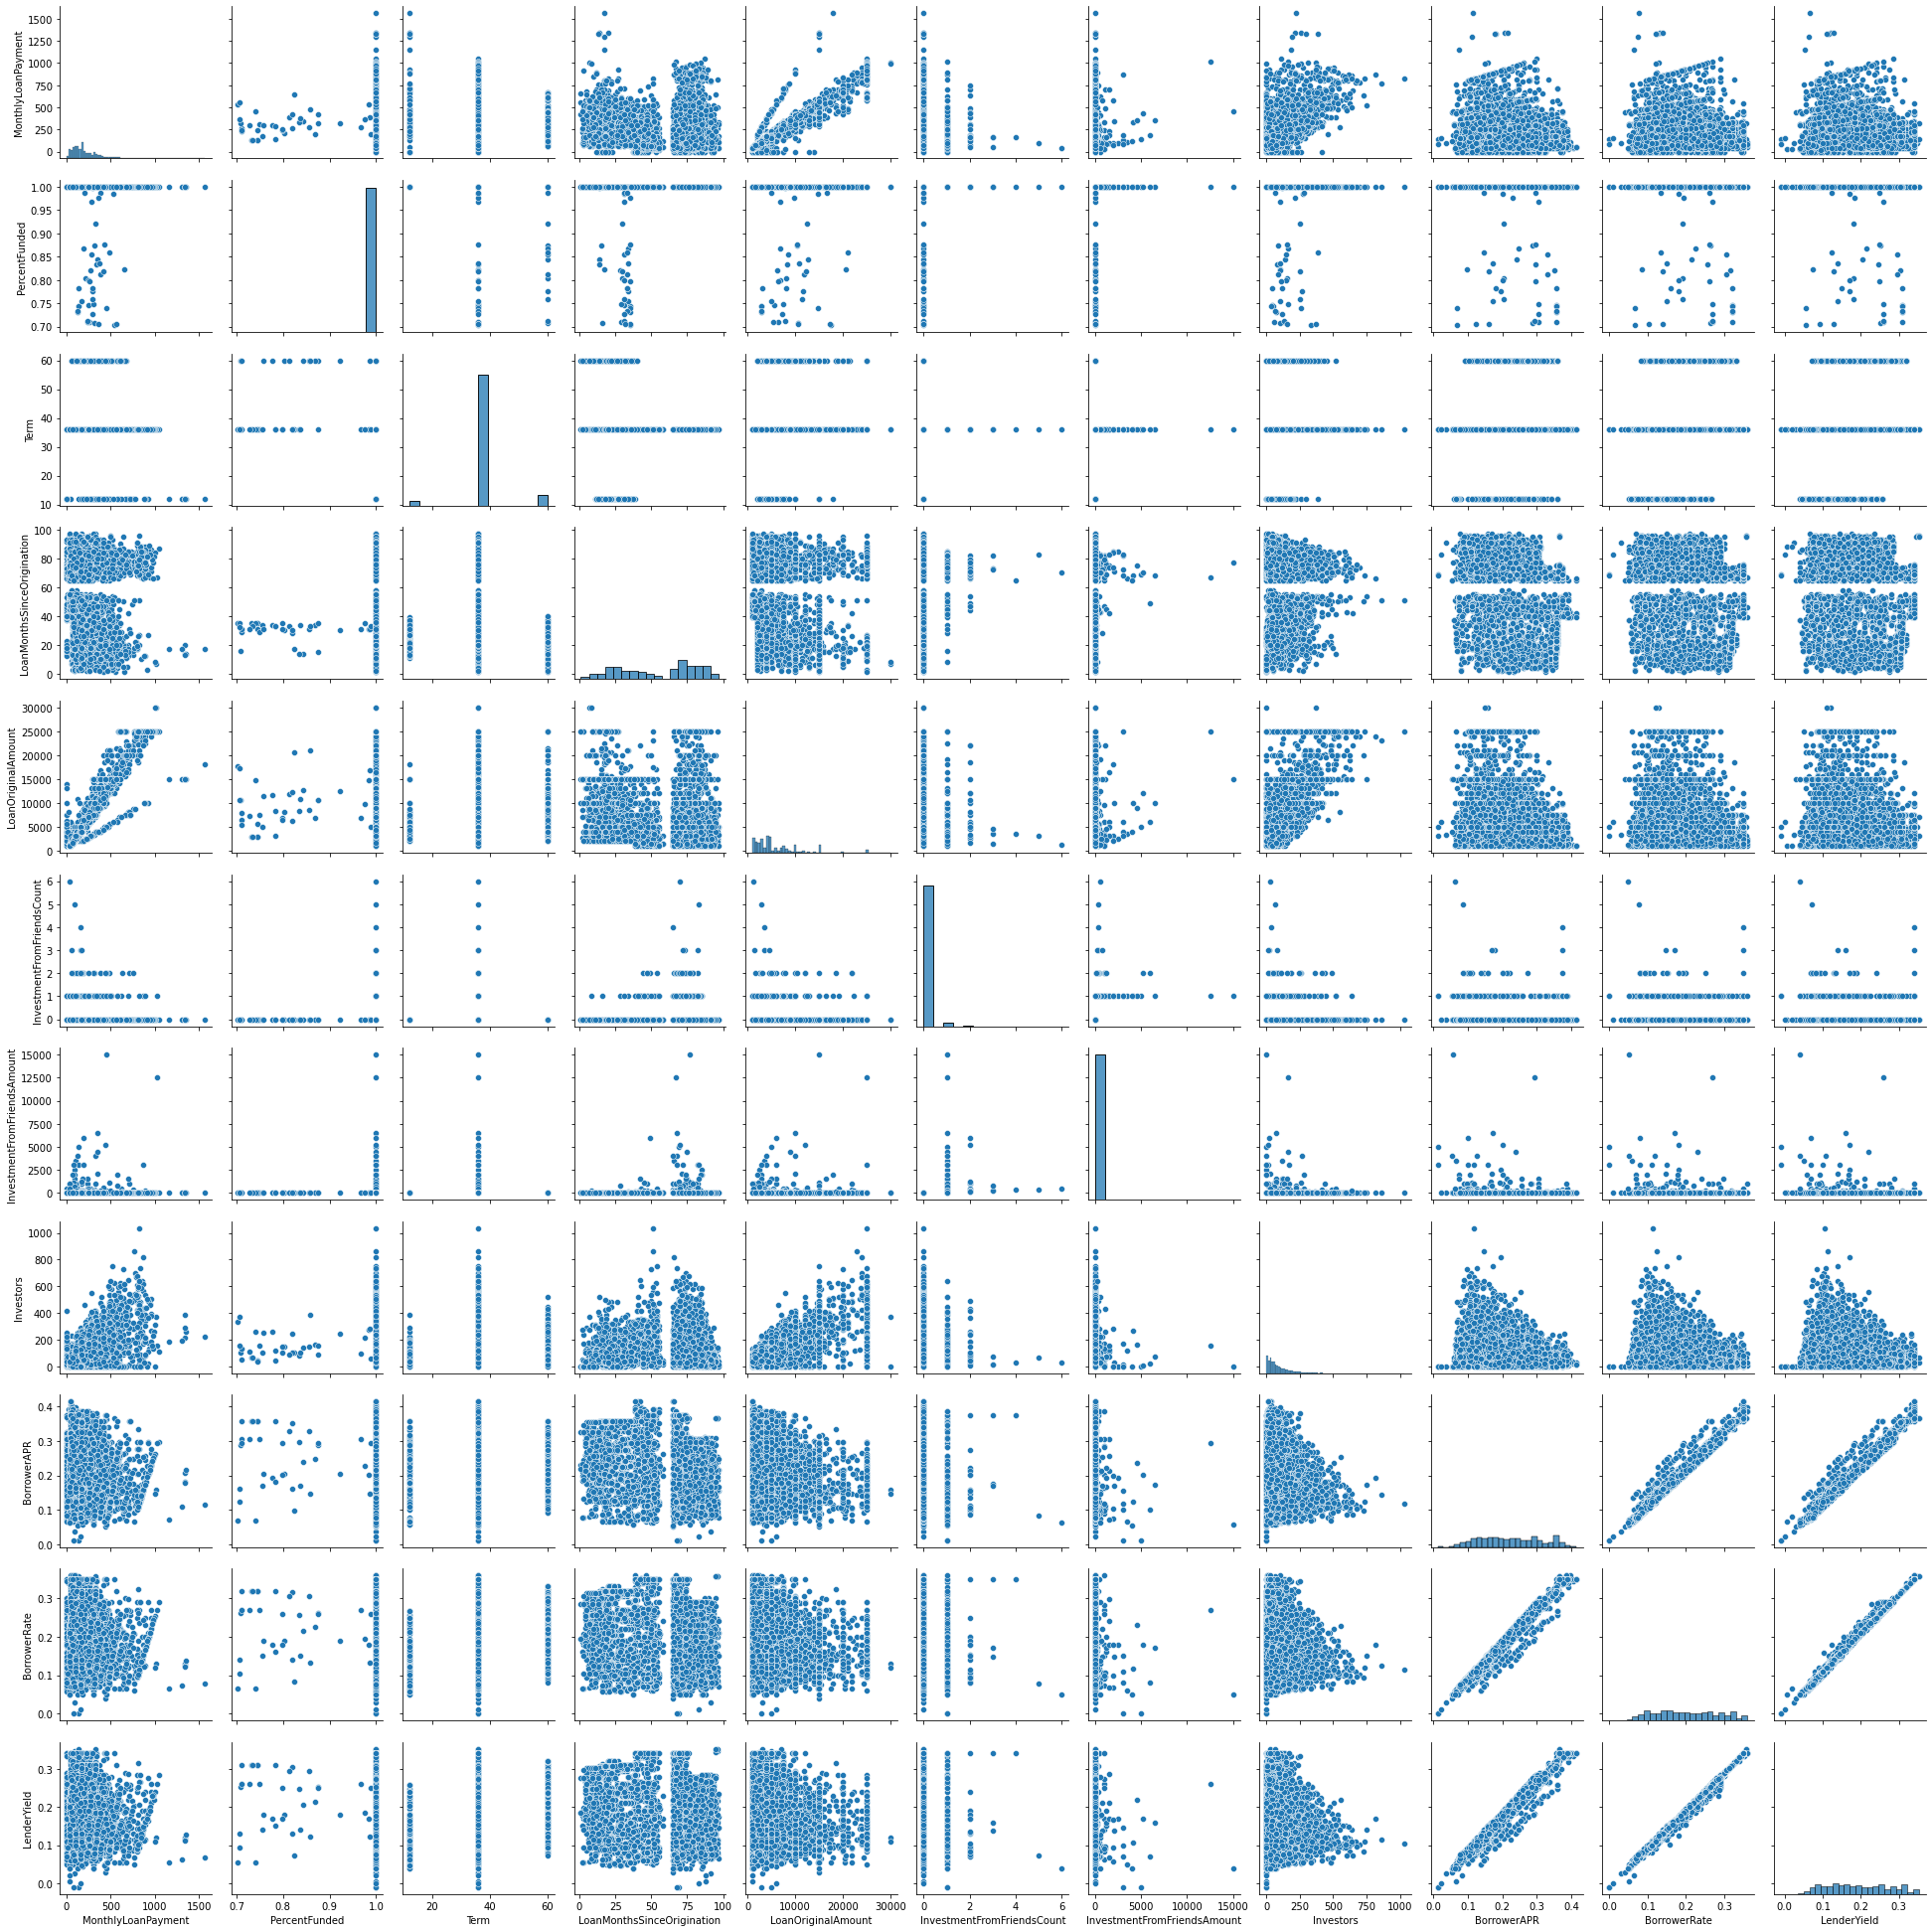

In [17]:
fig=plt.figure()

sns.pairplot(df_ft)
plt.savefig("Distributions_1_pairwise.png")

### Feature Selection-CORRELATION ANALYSIS

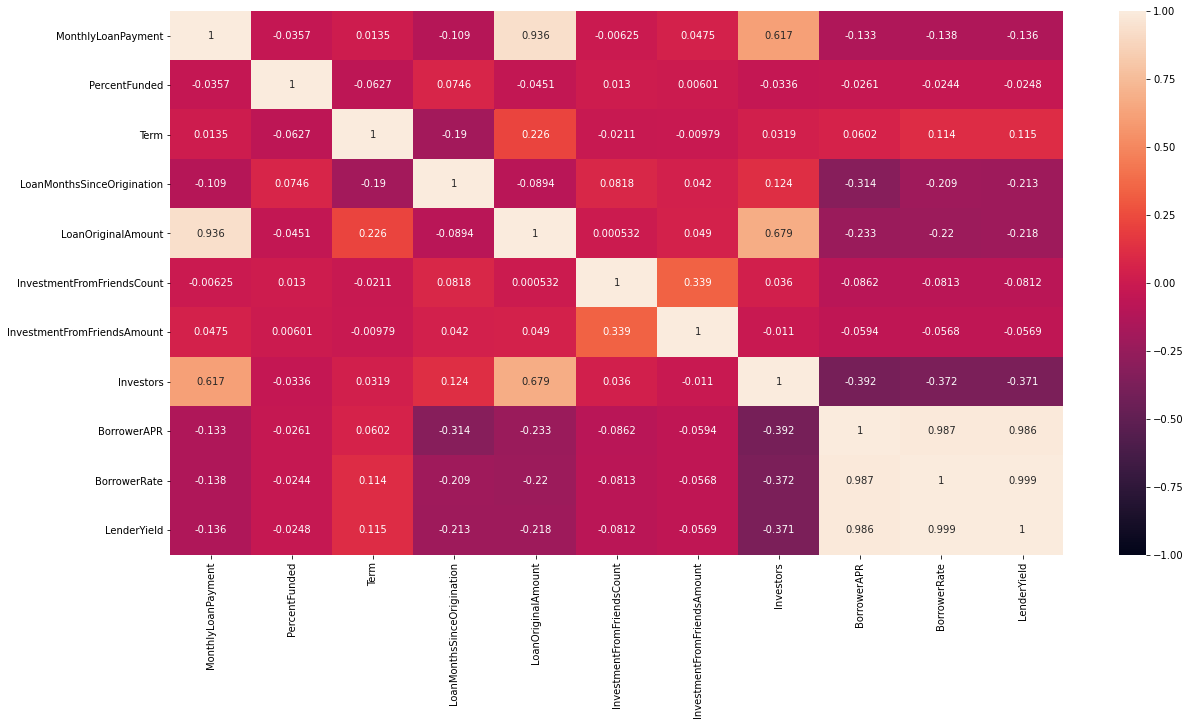

In [18]:
fig=plt.figure(figsize=[20,10])
sns.heatmap(df_ft.corr(), vmin=-1,vmax=1, annot=True,
           fmt=".3g");
plt.savefig("Corr_Heatmap.png")

In [19]:
df_ft.drop(["LoanOriginalAmount","BorrowerAPR", "LenderYield"],axis=1,inplace=True)

In [20]:
from scipy.stats.mstats import winsorize

winsorize(df_ft["MonthlyLoanPayment"],limits=(0.01,0.01),inplace=True)
winsorize(df_ft["InvestmentFromFriendsAmount"],limits=(0.01,0.01),inplace=True)
winsorize(df_ft["Investors"],limits=(0.01,0.01),inplace=True);

## Logistic Regression Model 

In [21]:
label_names=["Non-Default", "Default"]

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #To ensure a fair playing field*

y = sr_targets.values
X = df_ft.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

scaler=StandardScaler().fit(X_train)
x_Train=scaler.transform(X_train)
x_Test=scaler.transform(X_test)

print("The amount of instances in the target feature:", len(y))
print("The amount of instances in the target feature:", len(X))

The amount of instances in the target feature: 4979
The amount of instances in the target feature: 4979


In [23]:
logistic = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=1000)
logistic.fit(X_train, y_train)

pd.Series(logistic.coef_.squeeze(), index=list(df_ft.columns)).sort_values()

PercentFunded                 -1.865836
InvestmentFromFriendsCount    -0.381968
Investors                     -0.001977
InvestmentFromFriendsAmount    0.000601
MonthlyLoanPayment             0.001626
LoanMonthsSinceOrigination     0.012192
Term                           0.038791
BorrowerRate                   5.879100
dtype: float64

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = logistic.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)
print("The Accuracy score:",accuracy_score(y_test,y_pred)*100)

              precision    recall  f1-score   support

       False       0.69      0.92      0.79       657
        True       0.56      0.20      0.30       339

    accuracy                           0.67       996
   macro avg       0.62      0.56      0.54       996
weighted avg       0.64      0.67      0.62       996

The Accuracy score: 67.3694779116466


In [25]:
from sklearn.metrics import confusion_matrix
from lib.plots import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

random_state = np.random.RandomState(0) # exposes a number of methods for generating random numbers 
#drawn from a variety of probability distributions.
nb_folds=10
cv = StratifiedKFold(n_splits=6,shuffle=True, random_state=random_state)

Normalized confusion matrix
[[0.91628615 0.08371385]
 [0.79646018 0.20353982]]


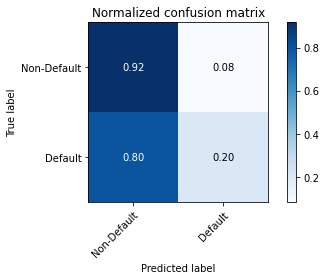

In [26]:
plot_confusion_matrix(y_test, y_pred, label_names, normalize=True);


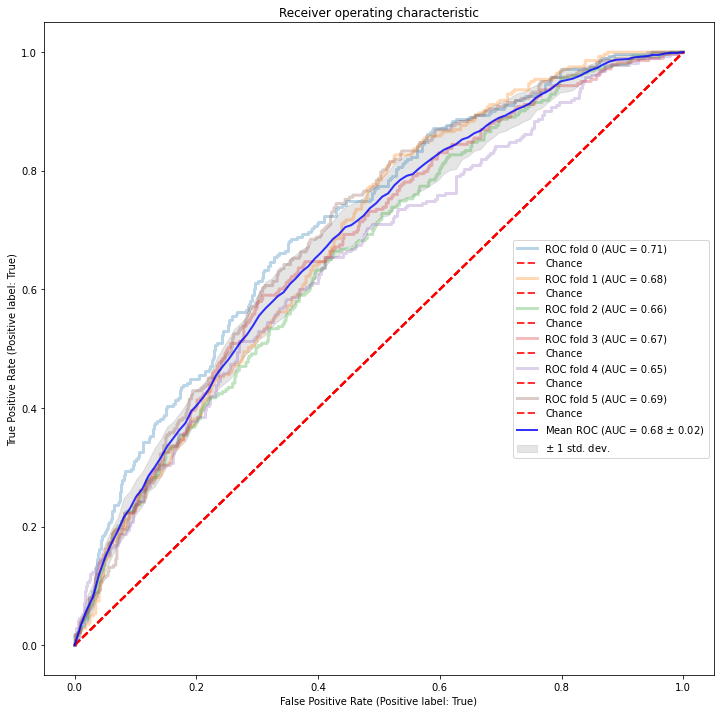

In [27]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax=plt.subplots(1,1,figsize=[12,12])
for i, (train, test) in enumerate(cv.split(X, y)):
    logistic.fit(X[train], y[train])
    viz = plot_roc_curve(logistic, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=3, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="center right")
plt.show()



### KNN NEIGHB.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
x_Train, x_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)
nk_class=KNeighborsClassifier(n_neighbors=5, weights='distance', 
                              algorithm='auto', leaf_size=5, p=1, metric='manhattan', 
                              metric_params=None, n_jobs=None)
nk_results=nk_class.fit(x_Train,y_Train)
pred=nk_class.predict(x_Test)

report_kn=classification_report(y_Test,pred)
print(report_kn)
print(confusion_matrix(y_Test,pred))

print("The Accuracy score:",accuracy_score(y_Test,pred)*100)

              precision    recall  f1-score   support

       False       0.68      0.75      0.72      1313
        True       0.40      0.32      0.36       679

    accuracy                           0.61      1992
   macro avg       0.54      0.54      0.54      1992
weighted avg       0.59      0.61      0.59      1992

[[990 323]
 [462 217]]
The Accuracy score: 60.592369477911646


Normalized confusion matrix
[[0.75399848 0.24600152]
 [0.68041237 0.31958763]]


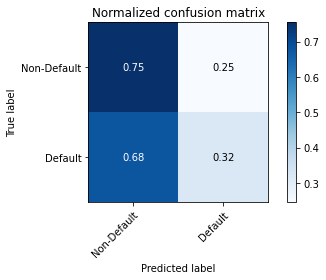

In [29]:
plot_confusion_matrix(y_Test, pred, label_names, normalize=True);

### SVM

In [30]:
from sklearn import svm 
svm_cl=svm.SVC(C=1.0, kernel='rbf', gamma='scale', 
               coef0=0.0, shrinking=True, probability=False, tol=0.001, 
               cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
               decision_function_shape='ovr', 
               break_ties=False, random_state=None)
svm_cl.fit(x_Train,y_Train)
pred_svm=svm_cl.predict(x_Test)

report_svm=classification_report(y_Test,pred_svm)
print(report_svm)
print(confusion_matrix(y_Test,pred_svm))

print("The Accuracy score:",accuracy_score(y_Test,pred_svm)*100)

              precision    recall  f1-score   support

       False       0.66      1.00      0.79      1313
        True       0.00      0.00      0.00       679

    accuracy                           0.66      1992
   macro avg       0.33      0.50      0.40      1992
weighted avg       0.43      0.66      0.52      1992

[[1311    2]
 [ 679    0]]
The Accuracy score: 65.8132530120482


Normalized confusion matrix
[[0.99847677 0.00152323]
 [1.         0.        ]]


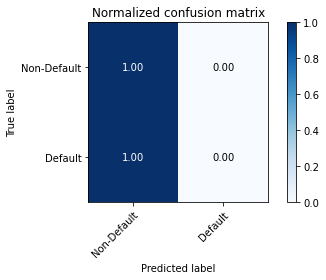

In [31]:
plot_confusion_matrix(y_Test, pred_svm, label_names, normalize=True);

### Decision Trees

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

nb_folds=10
#You can´t use normal Kfolds, but you need in this case the stratified version in which you make sure that everything stays
#roughly the same, despite being random.
cv=StratifiedKFold(n_splits=nb_folds,random_state=123,shuffle=True)
mdl_Tree=DecisionTreeClassifier(max_depth=100, random_state=123)

Y=sr_targets
X=df_ft

dct_precision={}
dct_recall={}

#Creating the class for the tree
for max_depth in np.arange(10):
    mdl_Tree=DecisionTreeClassifier( max_depth=max_depth)
    
    cv_results=cross_validate(mdl_Tree,X,Y,
                              cv=cv,scoring=["precision","recall", "f1"],
                              n_jobs=8)
    
    dct_precision[max_depth]=pd.DataFrame(cv_results).mean()["test_precision"]
    dct_recall[max_depth]=pd.DataFrame(cv_results).mean()["test_recall"]

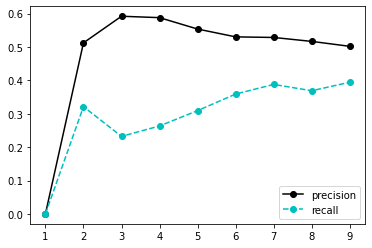

In [33]:
plt.plot(pd.Series(dct_precision),marker="o",label="precision",color="k")
plt.plot(pd.Series(dct_recall),marker="o",label="recall",linestyle="--",color="c")
plt.legend();
plt.savefig("Dec_Tree_Prec_Recall")

In [34]:
results=pd.DataFrame(cv_results)
results.to_latex#From the results one could determine that the optimal size of the tree is 5

<bound method NDFrame.to_latex of    fit_time  score_time  test_precision  test_recall   test_f1
0  0.036984    0.009991        0.509091     0.331361  0.401434
1  0.045972    0.012070        0.506849     0.437870  0.469841
2  0.040977    0.015990        0.507042     0.423529  0.461538
3  0.068954    0.010994        0.475000     0.335294  0.393103
4  0.062935    0.010991        0.430556     0.364706  0.394904
5  0.046973    0.011994        0.496454     0.411765  0.450161
6  0.043974    0.010995        0.515152     0.400000  0.450331
7  0.031938    0.010994        0.543103     0.370588  0.440559
8  0.041934    0.011992        0.496732     0.447059  0.470588
9  0.036976    0.011994        0.537879     0.420118  0.471761>

In [35]:
Tree_results=mdl_Tree.fit(x_Train,y_Train)
pred=mdl_Tree.predict(x_Test)

report_tree=classification_report(y_Test,pred)
print(report_tree)
print(confusion_matrix(y_Test,pred))

print("The Accuracy score:",accuracy_score(y_Test,pred)*100)

              precision    recall  f1-score   support

       False       0.70      0.82      0.76      1313
        True       0.49      0.33      0.39       679

    accuracy                           0.65      1992
   macro avg       0.59      0.57      0.57      1992
weighted avg       0.63      0.65      0.63      1992

[[1079  234]
 [ 458  221]]
The Accuracy score: 65.26104417670683


Normalized confusion matrix
[[0.82178218 0.17821782]
 [0.67452135 0.32547865]]


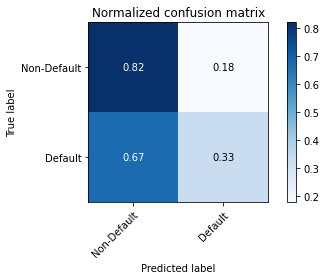

In [36]:
plot_confusion_matrix(y_Test, pred, label_names, normalize=True);

The depth of the tree: 9
The leaves of the tree: 180


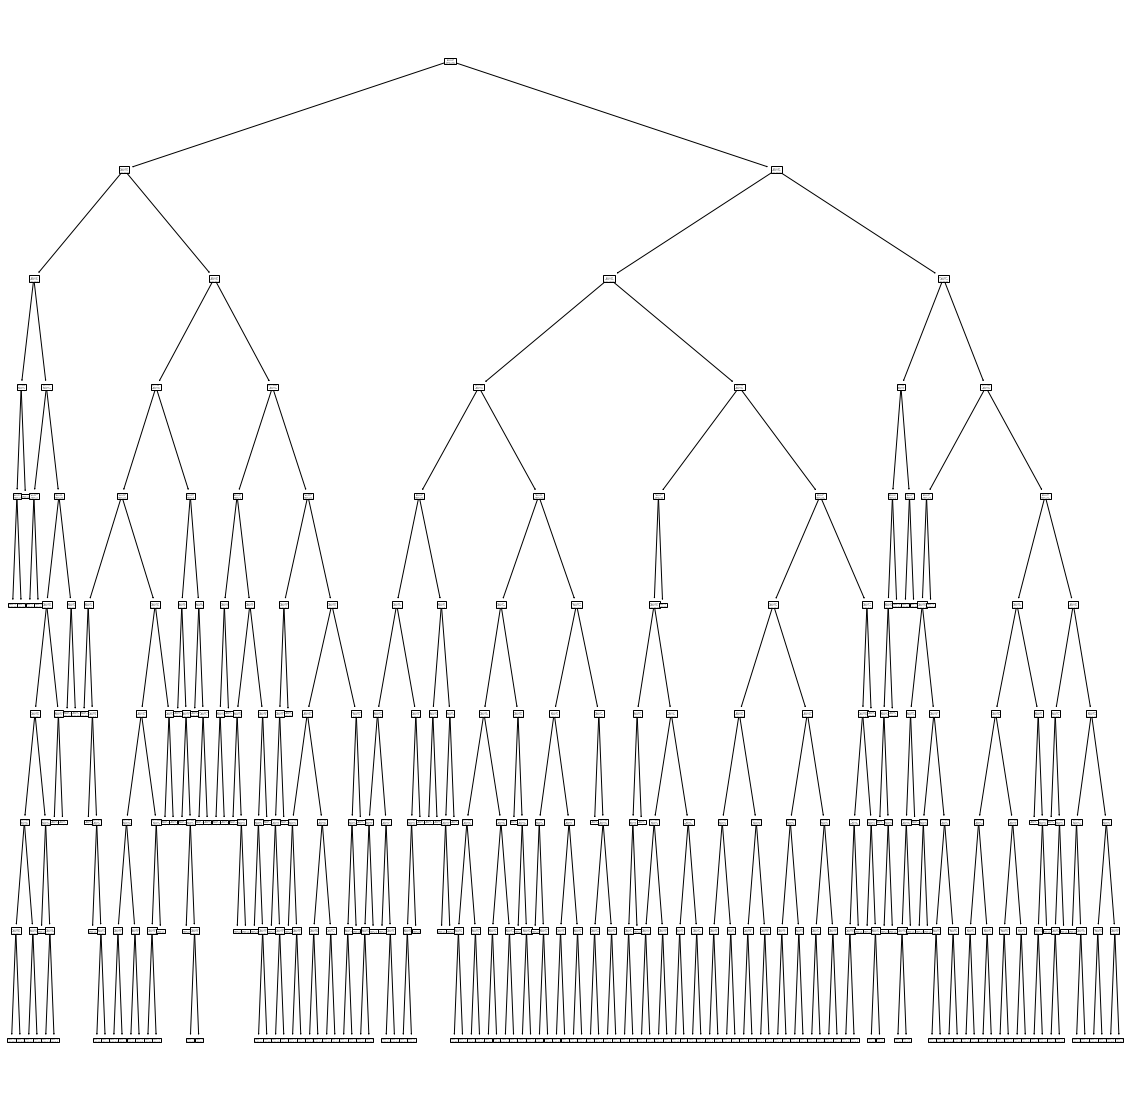

In [37]:
fig, plt.subplots(figsize=(20,20))
tree.plot_tree(mdl_Tree);
print("The depth of the tree:",mdl_Tree.get_depth())
print("The leaves of the tree:", mdl_Tree.get_n_leaves())
plt.savefig("Dec_Tree")